In [1]:
from google.colab import files
uploaded = files.upload()

Saving listingsSF.csv to listingsSF.csv


In [2]:
import pandas as pd
from sklearn.utils import resample
import io

listings = pd.read_csv(io.BytesIO(uploaded['listingsSF.csv']))
print(listings)

                      id                                      listing_url  \
0               50489368            https://www.airbnb.com/rooms/50489368   
1               53687935            https://www.airbnb.com/rooms/53687935   
2     623833252305593889  https://www.airbnb.com/rooms/623833252305593889   
3               53817024            https://www.airbnb.com/rooms/53817024   
4               54381390            https://www.airbnb.com/rooms/54381390   
...                  ...                                              ...   
7802             1018426             https://www.airbnb.com/rooms/1018426   
7803             1059961             https://www.airbnb.com/rooms/1059961   
7804            27558226            https://www.airbnb.com/rooms/27558226   
7805  619605575248018100  https://www.airbnb.com/rooms/619605575248018100   
7806             5242394             https://www.airbnb.com/rooms/5242394   

           scrape_id last_scraped           source  \
0     20240904163718 

# Data Cleaning

Checking all the attributes in the daatset


In [3]:
print(listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Removing unnecessary attributes from the daatset

In [4]:
#Before Dropping
print(listings.shape)

listings = listings.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'calendar_updated','license','calendar_last_scraped'], axis=1)

#After dropping
print(listings.shape)

(7807, 75)
(7807, 59)


Price column has \$ symbol and cannot be processed as a numerical column. So, removing the \$ sign and converting it to float

In [5]:
# Ensure that the 'price' column is treated as a string first
listings['price'] = listings['price'].astype(str)

# Remove the $ symbol and commas using regex, then convert to numeric
listings['price'] = listings['price'].str.replace(r'[$,]', '', regex=True)

# Convert the cleaned 'price' column to a numeric type
listings['price'] = pd.to_numeric(listings['price'], errors='coerce')

# Check the result
print(listings['price'].head())
print(listings['price'].dtype)

0      NaN
1      NaN
2    132.0
3      NaN
4      NaN
Name: price, dtype: float64
float64


Checking if any of the numerical attributes have string or text data

In [6]:
# Convert the specified columns to numeric, coerce errors to NaN
cols_to_check = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms', 'bathrooms', 'beds', 'accommodates',
                 'availability_30', 'availability_365', 'number_of_reviews_ltm','review_scores_rating']

# Function to check if values are non-numeric
def count_non_numeric(series):
    # This will return True for non-numeric values (strings or text)
    return series.apply(pd.to_numeric, errors='coerce').isna().sum()

# Apply the function to each column and get the count of non-numeric rows per column
non_numeric_counts = listings[cols_to_check].apply(count_non_numeric)

# Output the result
print("Number of rows with non-numeric values for each column:")
print(non_numeric_counts)



Number of rows with non-numeric values for each column:
price                    1649
minimum_nights              0
maximum_nights              0
number_of_reviews           0
bedrooms                  456
bathrooms                1654
beds                     1705
accommodates                0
availability_30             0
availability_365            0
number_of_reviews_ltm       0
review_scores_rating     1771
dtype: int64


Cleaning the text attributes room_type

In [7]:
# Remove leading/trailing spaces
listings['room_type'] = listings['room_type'].str.strip()

# Standardize text to lowercase
listings['room_type'] = listings['room_type'].str.lower()


Checking for missing values in the text attributes room_type and neighbourhood_cleansed

In [8]:
import pandas as pd

# Specify the columns to check for missing values
columns_to_check = ['room_type', 'neighbourhood_cleansed']

# Get the count of missing values for the specified columns
missing_values = listings[columns_to_check].isnull().sum()

# Display the number of missing values for these columns
print(missing_values)


room_type                 0
neighbourhood_cleansed    0
dtype: int64


Converting the amenities in each row into a numerical attribute in order to be used for further analysis.

In [9]:
# Function to clean and count the number of amenities in each record
def count_amenities(amenities_str):
    # Decode special characters and remove unnecessary characters like quotes, square brackets, etc.
    cleaned_amenities_str = amenities_str.encode('utf-8').decode('unicode_escape').strip('[]').replace('"', '')

    # Split the cleaned string into a list of amenities
    amenities_list = cleaned_amenities_str.split(', ')

    # Return the count of amenities
    return len(amenities_list)

# Apply the function to each record in the 'amenities' column
listings['amenities_count'] = listings['amenities'].apply(lambda x: count_amenities(x))

# Display the updated DataFrame with the new column
print(listings[['amenities', 'amenities_count']])

                                              amenities  amenities_count
0     ["Essentials", "Kitchen", "Stainless steel sto...               23
1     ["Hair dryer", "Courtyard view", "Essentials",...               68
2     ["Shared hot tub", "Hair dryer", "Courtyard vi...               62
3     ["Shared hot tub", "Hair dryer", "Courtyard vi...               53
4     ["Hair dryer", "Courtyard view", "Essentials",...               60
...                                                 ...              ...
7802  ["Hair dryer", "Elevator", "Essentials", "Heat...               36
7803  ["Hair dryer", "Shampoo", "Essentials", "Dryer...               15
7804  ["Hair dryer", "Essentials", "Private entrance...               13
7805  ["Hair dryer", "Essentials", "Private entrance...               56
7806  ["Hair dryer", "Essentials", "Private entrance...               40

[7807 rows x 2 columns]


# Task 1: Descriptive Statistics

Calculate summary statistics for numerical features such as `price`,
`minimum_nights`, `maximum_nights`, `number_of_reviews`, and
`review_scores_rating`. Understand the central tendency, dispersion, and
distribution of these variables.

In [10]:
# List of numerical features to analyze
numerical_features = ['price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']

# Additional features for analysis
additional_numerical_features = ['accommodates','availability_30', 'availability_365', 'number_of_reviews_ltm']

Removing null values from the required numerical features

In [11]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[numerical_features] = listings[numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_1 = listings.dropna(subset=numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_1)

# Verify that all specified columns are numerical
print(listings_1[numerical_features].dtypes)

                      id                                               name  \
2     623833252305593889         Massive 1-bedroom condo in the heart of SF   
6               51508029  Orange Village Hostel -Full Size Bed w/shared ...   
8     565272991337321502   Orange Village Hostel- 3  Bed Room w/shared bath   
9               50489340   Orange Village Hostel - Full Size Bed w/Bathroom   
10              50623131       Orange Village Hostel - Twin Beds w/Bathroom   
...                  ...                                                ...   
7800            10550345                Timeshare - Club Donatello Union-Sq   
7802             1018426  SHARE Spacious Loft: Moscone, Ball Park & Down...   
7803             1059961                       KelSoMa 1 Bed & Bath in SoMa   
7805  619605575248018100    Elegant & Chic Home with Magic Garden in Bernal   
7806             5242394                      Private Cozy Studio Flat  4U!   

                                            descrip

Calculating the summary statistics for the required numerical values

In [12]:
# Calculate summary statistics for the numerical features
summary_statistics = listings_1[numerical_features].describe()

# Display the summary statistics
print("Summary Statistics:")
print(summary_statistics)

Summary Statistics:
              price  minimum_nights  maximum_nights  number_of_reviews  \
count   4891.000000      4891.00000     4891.000000        4891.000000   
mean     234.636066        16.61971      583.399714          74.043549   
std     1050.443381        31.58870    14300.886054         125.393563   
min       25.000000         1.00000        1.000000           1.000000   
25%       99.000000         2.00000       29.000000           5.000000   
50%      148.000000         3.00000      182.000000          21.000000   
75%      235.000000        30.00000      365.000000          87.000000   
max    50000.000000       365.00000   999999.000000        1239.000000   

       review_scores_rating  
count           4891.000000  
mean               4.790681  
std                0.374915  
min                1.000000  
25%                4.750000  
50%                4.910000  
75%                5.000000  
max                5.000000  


Removing null values from the additional numerical features

In [13]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[additional_numerical_features] = listings[additional_numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_2 = listings.dropna(subset=additional_numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_2)

# Verify that all specified columns are numerical
print(listings_2[additional_numerical_features].dtypes)

                      id                                               name  \
0               50489368  (B) Furnished Efficiency Studio near Union Square   
1               53687935   2 Private Rooms in SF. Walk to Bart. Modern Home   
2     623833252305593889         Massive 1-bedroom condo in the heart of SF   
3               53817024      Large 1-bedroom in a condo in the heart of SF   
4               54381390                Cozy 1-bedroom condo with roof deck   
...                  ...                                                ...   
7802             1018426  SHARE Spacious Loft: Moscone, Ball Park & Down...   
7803             1059961                       KelSoMa 1 Bed & Bath in SoMa   
7804            27558226  SanFrancisco Fully Furnished Studio/Apt clean&...   
7805  619605575248018100    Elegant & Chic Home with Magic Garden in Bernal   
7806             5242394                      Private Cozy Studio Flat  4U!   

                                            descrip

Calculating the summary statistics for the additional numerical features

In [14]:
# Calculate summary statistics for the numerical features
summary_statistics = listings_2[additional_numerical_features].describe()

# Display the summary statistics
print("Summary Statistics:")
print(summary_statistics)

Summary Statistics:
       accommodates  availability_30  availability_365  number_of_reviews_ltm
count   7807.000000      7807.000000       7807.000000            7807.000000
mean       3.201614        11.304214        181.709620               8.701934
std        1.989553        11.497989        133.364698              18.817044
min        1.000000         0.000000          0.000000               0.000000
25%        2.000000         0.000000         54.000000               0.000000
50%        2.000000         7.000000        175.000000               1.000000
75%        4.000000        23.000000        320.000000               7.000000
max       16.000000        30.000000        365.000000             378.000000


Calculating the values variance, skewness, kurtosis for understanding the central tendency, dispersion

In [15]:
# Calculate variance
variance_values1 = listings_1[numerical_features].var()
variance_values2 = listings_2[additional_numerical_features].var()
print("\nVariance Values:")
print(variance_values1)
print(variance_values2)

# Calculate skewness
skewness_values1 = listings_1[numerical_features].skew()
skewness_values2 = listings_2[additional_numerical_features].skew()
print("\nSkewness Values:")
print(skewness_values1)
print(skewness_values2)

# Calculate kurtosis
kurtosis_values1 = listings_1[numerical_features].kurt()
kurtosis_values2 = listings_2[additional_numerical_features].kurt()
print("\nKurtosis Values:")
print(kurtosis_values1)
print(kurtosis_values2)


Variance Values:
price                   1.103431e+06
minimum_nights          9.978459e+02
maximum_nights          2.045153e+08
number_of_reviews       1.572355e+04
review_scores_rating    1.405615e-01
dtype: float64
accommodates                 3.958322
availability_30            132.203752
availability_365         17786.142545
number_of_reviews_ltm      354.081143
dtype: float64

Skewness Values:
price                   43.799150
minimum_nights           8.265359
maximum_nights          69.826285
number_of_reviews        3.178851
review_scores_rating    -4.914173
dtype: float64
accommodates             1.929671
availability_30          0.504203
availability_365        -0.005453
number_of_reviews_ltm    5.469706
dtype: float64

Kurtosis Values:
price                   2061.836944
minimum_nights            86.345122
maximum_nights          4880.785404
number_of_reviews         13.706566
review_scores_rating      35.649865
dtype: float64
accommodates              6.002919
availability_

# 2. Distribution Analysis

Plot histograms or density plots for key numerical features like price,minimum_nights, and review_scores_rating. Analyze the distribution of these features to identify any skewness or outliers.

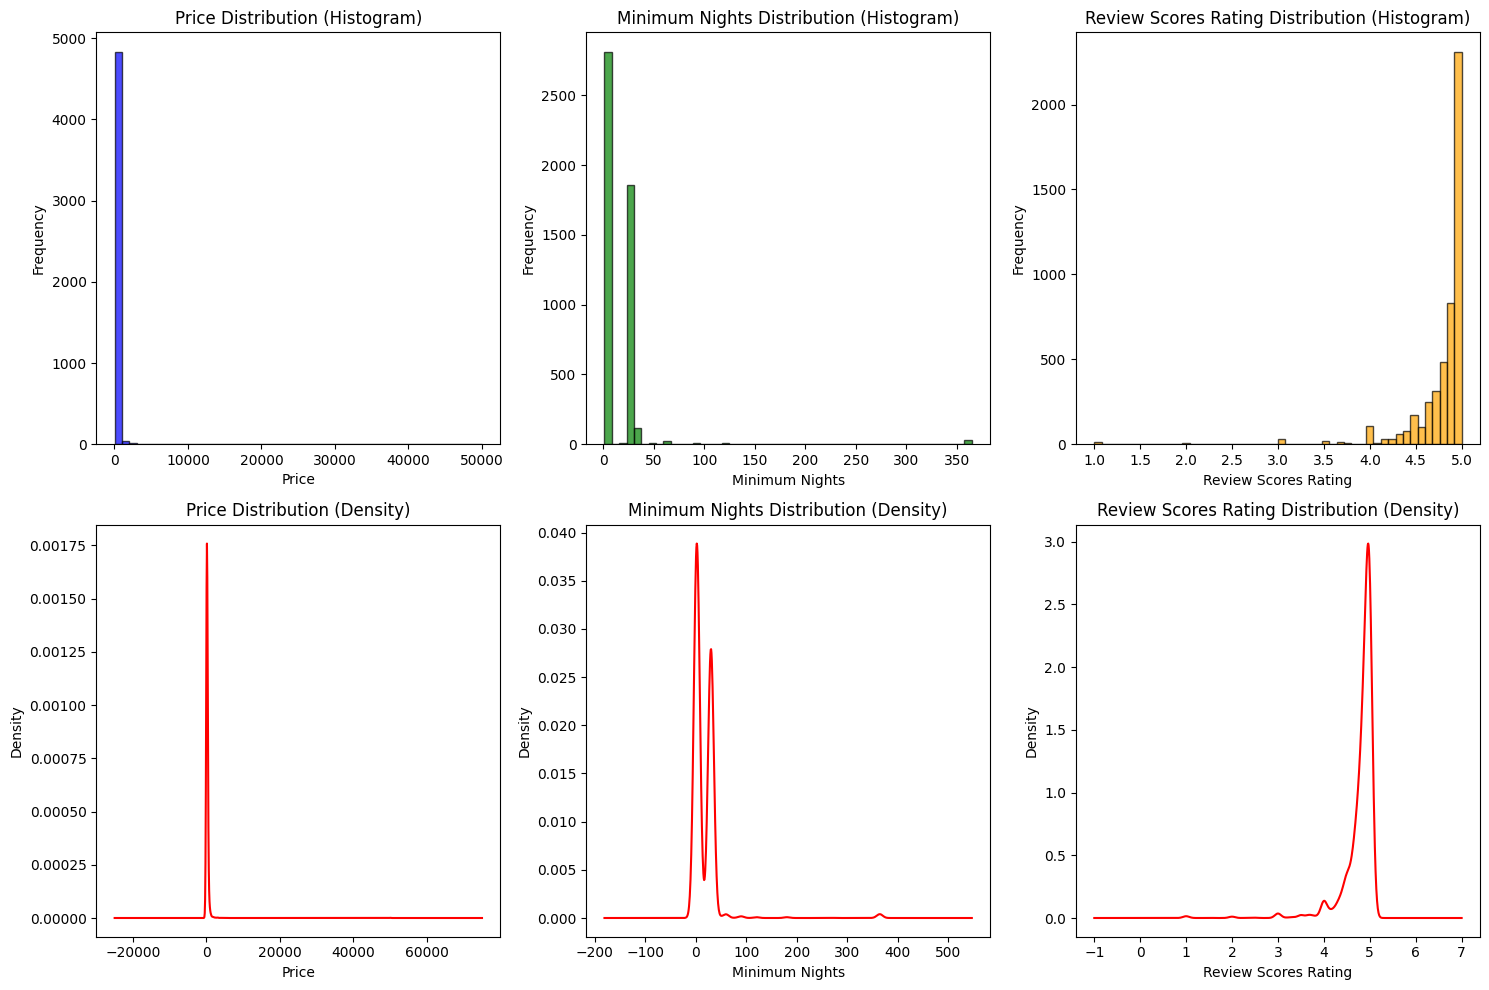

In [16]:
import matplotlib.pyplot as plt

# Plot histograms and density plots for key numerical features
plt.figure(figsize=(15, 10))

# Price histogram
plt.subplot(2, 3, 1)
plt.hist(listings_1['price'], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Price Distribution (Histogram)')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Price density plot
plt.subplot(2, 3, 4)
listings_1['price'].plot(kind='kde', color='red')
plt.title('Price Distribution (Density)')
plt.xlabel('Price')
plt.ylabel('Density')

# Minimum nights histogram
plt.subplot(2, 3, 2)
plt.hist(listings_1['minimum_nights'], bins=50, color='green', edgecolor='black', alpha=0.7)
plt.title('Minimum Nights Distribution (Histogram)')
plt.xlabel('Minimum Nights')
plt.ylabel('Frequency')

# Minimum nights density plot
plt.subplot(2, 3, 5)
listings_1['minimum_nights'].plot(kind='kde', color='red')
plt.title('Minimum Nights Distribution (Density)')
plt.xlabel('Minimum Nights')
plt.ylabel('Density')

# Review scores rating histogram
plt.subplot(2, 3, 3)
plt.hist(listings_1['review_scores_rating'].dropna(), bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.title('Review Scores Rating Distribution (Histogram)')
plt.xlabel('Review Scores Rating')
plt.ylabel('Frequency')

# Review scores rating density plot
plt.subplot(2, 3, 6)
listings_1['review_scores_rating'].dropna().plot(kind='kde', color='red')
plt.title('Review Scores Rating Distribution (Density)')
plt.xlabel('Review Scores Rating')
plt.ylabel('Density')

# Show the plot
plt.tight_layout()
plt.show()

# 3. Correlation Analysis

Create a correlation matrix to explore relationships between numerical variables such as price, number_of_reviews, availability_365, and review_scores_rating. Identify any strong correlations that might be useful for predictive modeling or further investigation.

Plotting correlation matrix and heatmap for the required attributes

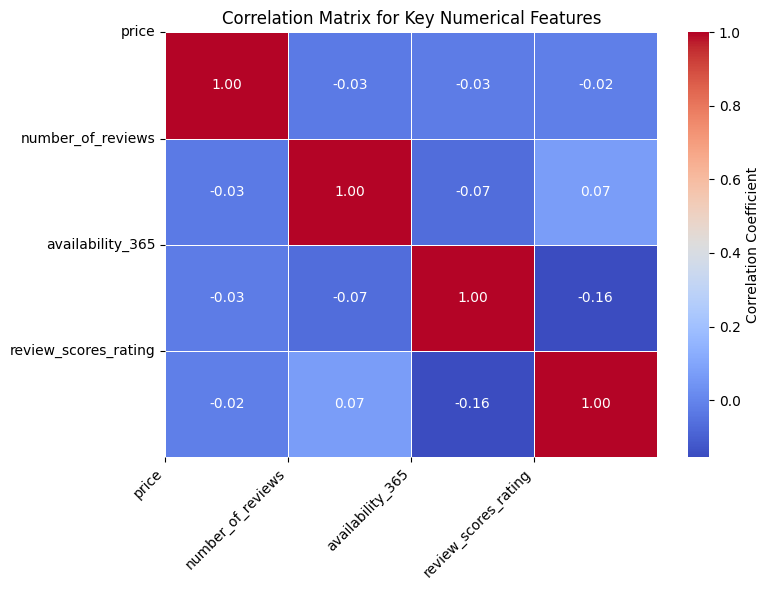

,price,number_of_reviews,availability_365,review_scores_rating
price,1.000000,-0.032059,-0.027463,-0.018464
number_of_reviews,-0.032059,1.000000,-0.066895,0.072505
availability_365,-0.027463,-0.066895,1.000000,-0.155338
review_scores_rating,-0.018464,0.072505,-0.155338,1.000000


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#List of columns
correlation_columns = ['price', 'number_of_reviews', 'availability_365', 'review_scores_rating']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_3 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_3[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix

Plotting correlation matrix and heatmap for additional attributes

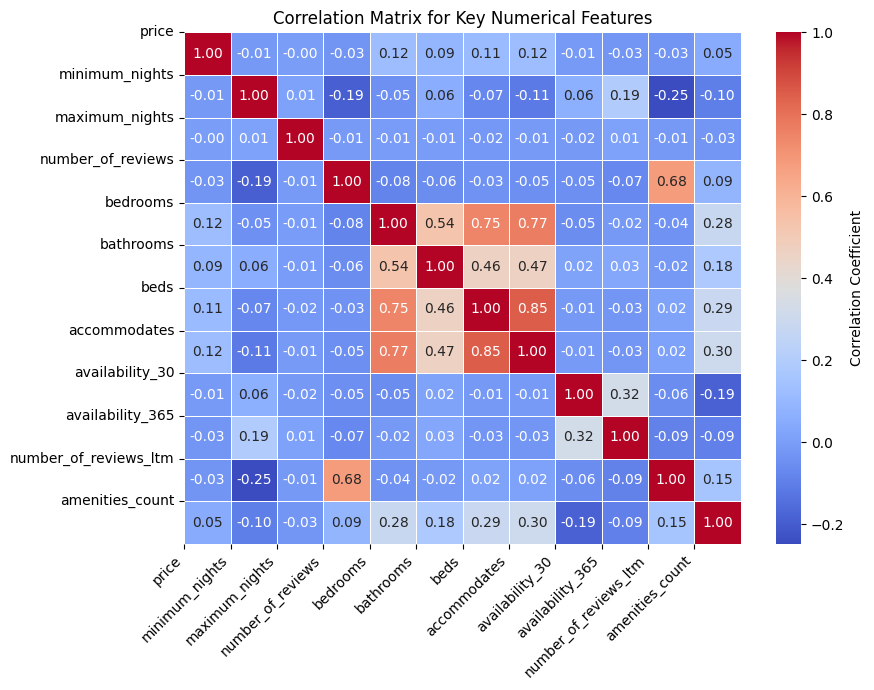

,price,minimum_nights,maximum_nights,number_of_reviews,bedrooms,bathrooms,beds,accommodates,availability_30,availability_365,number_of_reviews_ltm,amenities_count
price,1.000000,-0.014199,-0.002838,-0.032488,0.118520,0.090013,0.109653,0.120792,-0.013073,-0.027759,-0.028517,0.046292
minimum_nights,-0.014199,1.000000,0.013550,-0.190406,-0.045700,0.057290,-0.073751,-0.111950,0.061579,0.192666,-0.247259,-0.100228
maximum_nights,-0.002838,0.013550,1.000000,-0.010926,-0.006264,-0.006462,-0.021652,-0.009526,-0.015355,0.013396,-0.014598,-0.026809
number_of_reviews,-0.032488,-0.190406,-0.010926,1.000000,-0.084953,-0.056882,-0.034557,-0.050604,-0.047703,-0.067831,0.680494,0.085308
bedrooms,0.118520,-0.045700,-0.006264,-0.084953,1.000000,0.536527,0.750882,0.768100,-0.052661,-0.016540,-0.036722,0.279939
bathrooms,0.090013,0.057290,-0.006462,-0.056882,0.536527,1.000000,0.464638,0.465933,0.017536,0.033635,-0.016460,0.178996
beds,0.109653,-0.073751,-0.021652,-0.034557,0.750882,0.464638,1.000000,0.849401,-0.014297,-0.026392,0.019547,0.285595
accommodates,0.120792,-0.111950,-0.009526,-0.050604,0.768100,0.465933,0.849401,1.000000,-0.011397,-0.027472,0.015060,0.303533
availability_30,-0.013073,0.061579,-0.015355,-0.047703,-0.052661,0.017536,-0.014297,-0.011397,1.000000,0.324101,-0.057054,-0.188105
availability_365,-0.027759,0.192666,0.013396,-0.067831,-0.016540,0.033635,-0.026392,-0.027472,0.324101,1.000000,-0.087055,-0.091563


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#List of columns
correlation_columns = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms','bathrooms','beds','accommodates','availability_30','availability_365','number_of_reviews_ltm','amenities_count']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_4 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_4[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix


# 4. Price Analysis

Analyze the distribution of prices across different neighborhoods (host_neighbourhood) or room types (if available). Understand which neighborhoods have higher or lower average prices and whether certain neighborhoods are more popular for shortterm or longterm stays.

Average Price by Neighborhood:
neighbourhood_cleansed
Castro/Upper Market      515.197531
Russian Hill             411.150685
Pacific Heights          377.529032
Western Addition         354.745921
Inner Richmond           351.016393
Financial District       348.696429
Presidio                 297.000000
Marina                   293.931579
Twin Peaks               290.851852
Diamond Heights          279.416667
Seacliff                 275.250000
North Beach              267.897638
Presidio Heights         260.529412
Haight Ashbury           249.753488
Noe Valley               248.741379
Potrero Hill             243.074074
Inner Sunset             235.127119
South of Market          222.128421
Bernal Heights           217.436364
Nob Hill                 201.533101
Treasure Island/YBI      200.000000
West of Twin Peaks       198.813953
Chinatown                198.463918
Downtown/Civic Center    197.287621
Glen Park                180.736842
Outer Richmond           178.608939
Mission   

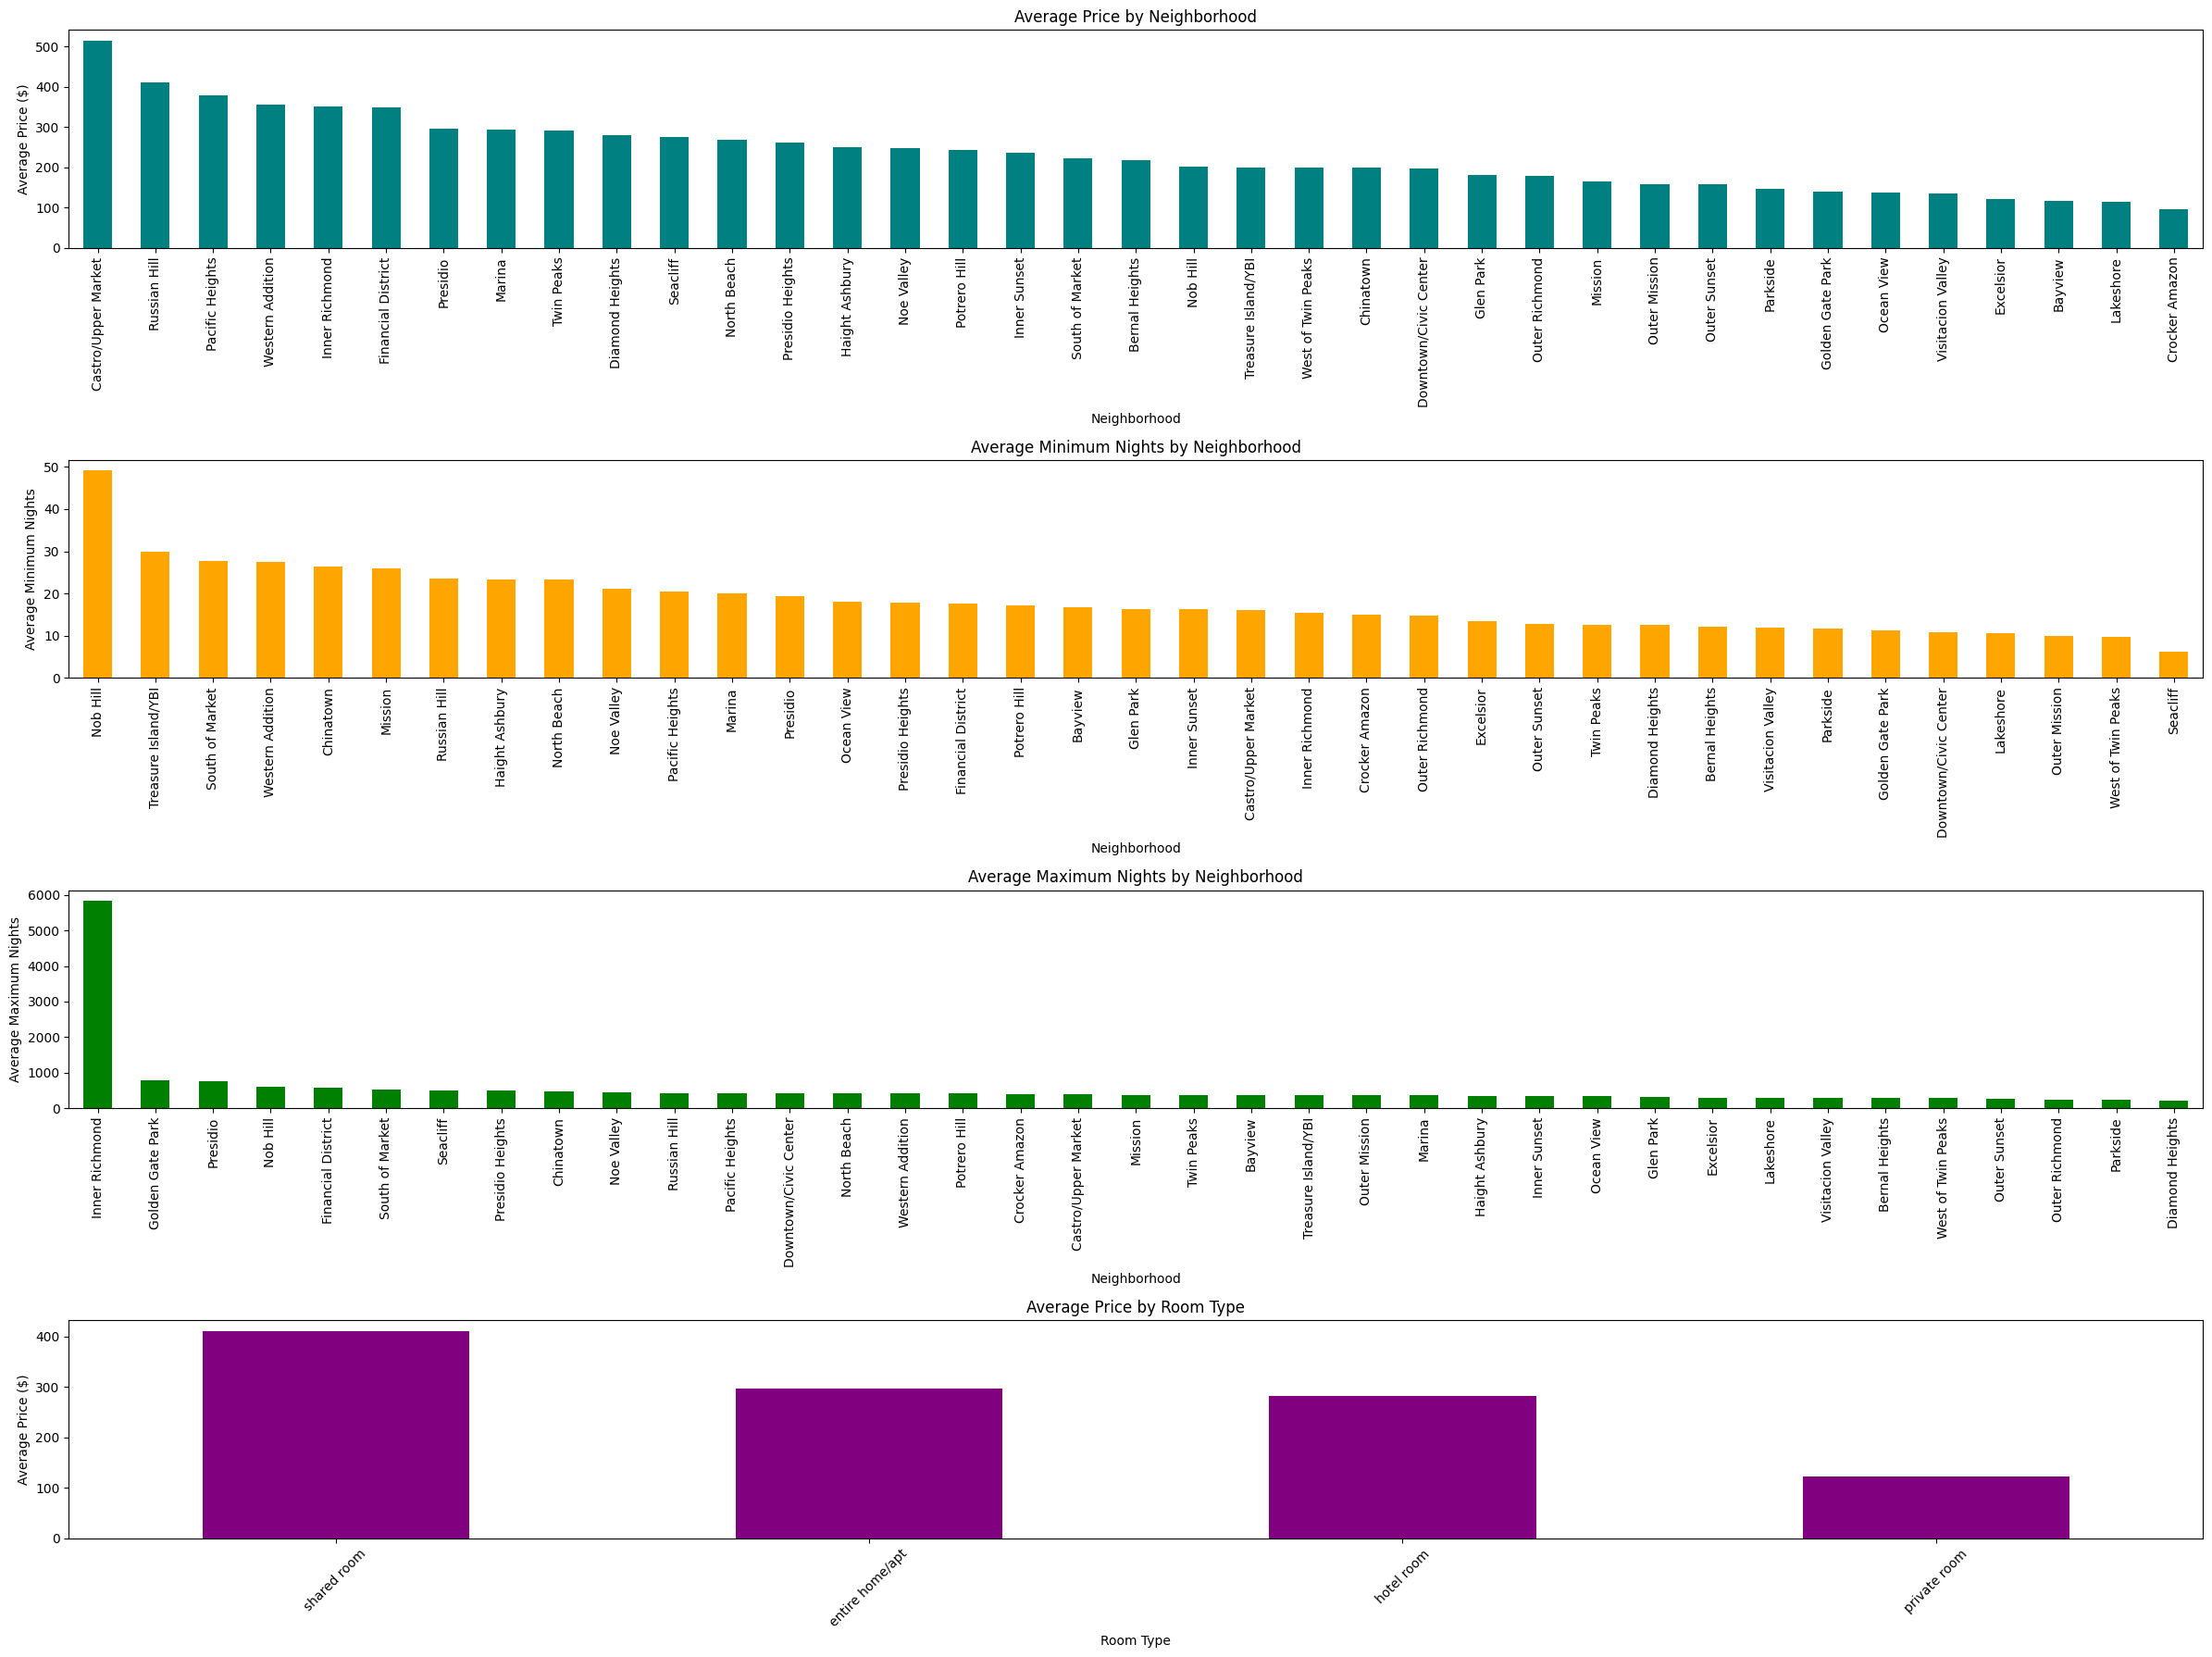

<Figure size 1600x800 with 0 Axes>

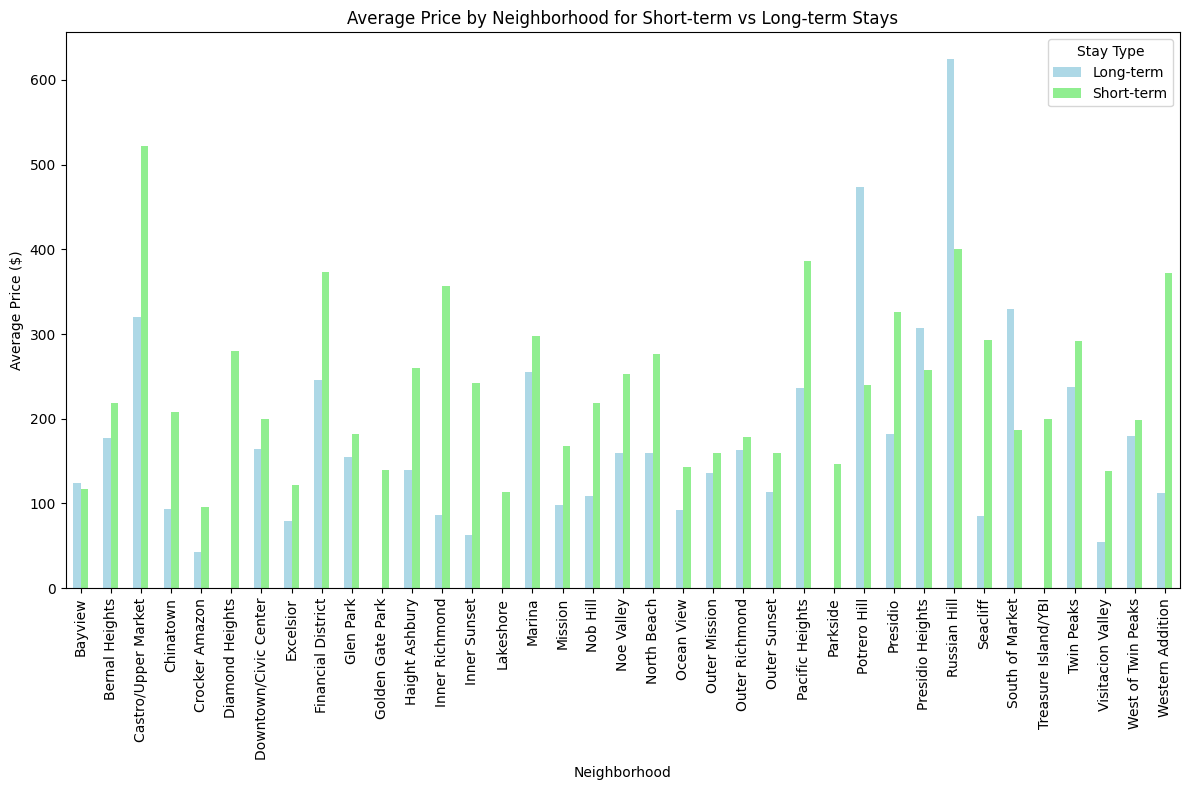

<Figure size 800x600 with 0 Axes>

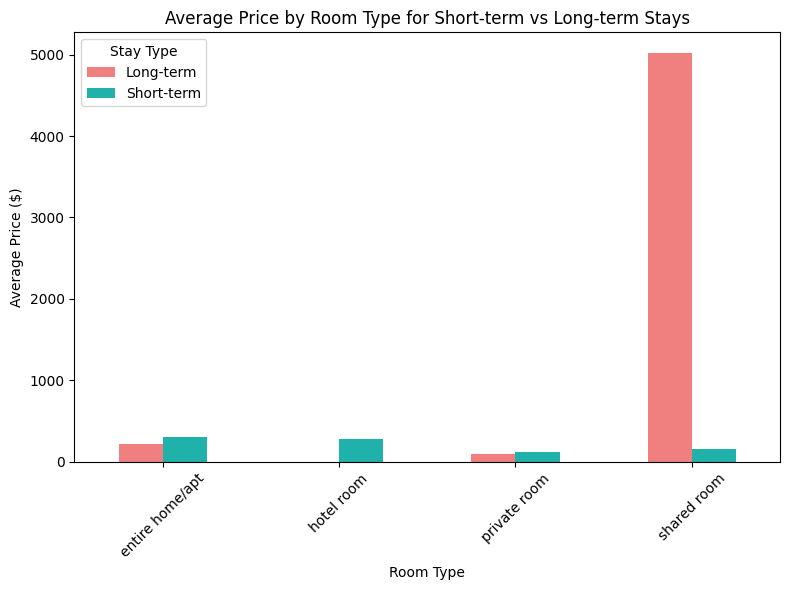

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

listings['stay_type'] = listings['minimum_nights'].apply(lambda x: 'Long-term' if x > 30 else 'Short-term')

# Extracting relevant columns for price analysis: price, neighbourhood_cleansed, room_type, and minimum_nights
price_analysis_columns = ['price', 'neighbourhood_cleansed', 'room_type', 'minimum_nights', 'maximum_nights', 'stay_type']

# Creating the price_analysis_data DataFrame
price_analysis_data = listings[price_analysis_columns].dropna()

# Calculating average price per neighborhood
avg_price_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Calculating average minimum/maximum nights per neighborhood (to understand short-term vs long-term stays)
avg_minimum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['minimum_nights'].mean().sort_values(ascending=False)
avg_maximum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['maximum_nights'].mean().sort_values(ascending=False)

# Calculating average price per room type
avg_price_room_type = price_analysis_data.groupby('room_type')['price'].mean().sort_values(ascending=False)

# Calculate average price for short-term and long-term stays by neighborhood
avg_price_neighbourhood_stay_type = price_analysis_data.groupby(['neighbourhood_cleansed', 'stay_type'])['price'].mean().unstack().fillna(0)

# Calculate average price for short-term and long-term stays by room type
avg_price_room_type_stay_type = price_analysis_data.groupby(['room_type', 'stay_type'])['price'].mean().unstack().fillna(0)

# Displaying the results
print("Average Price by Neighborhood:")
print(avg_price_neighbourhood)

print("\nAverage Minimum Nights by Neighborhood:")
print(avg_minimum_nights_neighbourhood)

print("\nAverage Maximum Nights by Neighborhood:")
print(avg_maximum_nights_neighbourhood)

print("\nAverage Price by Room Type:")
print(avg_price_room_type)

print("\nAverage Price by Neighborhood and Stay Type:")
print(avg_price_neighbourhood_stay_type)

print("\nAverage Price by Room Type and Stay Type:")
print(avg_price_room_type_stay_type)

# Plotting price and minimum nights distributions across neighborhoods and room types
plt.figure(figsize=(24, 18))

# Average price by neighborhood
plt.subplot(4, 1, 1)
avg_price_neighbourhood.plot(kind='bar', color='teal')
plt.title('Average Price by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)

# Average minimum nights by neighborhood
plt.subplot(4, 1, 2)
avg_minimum_nights_neighbourhood.plot(kind='bar', color='orange')
plt.title('Average Minimum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Minimum Nights')
plt.xticks(rotation=90)

# Average maximum nights by neighborhood
plt.subplot(4, 1, 3)
avg_maximum_nights_neighbourhood.plot(kind='bar', color='green')
plt.title('Average Maximum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Maximum Nights')
plt.xticks(rotation=90)

# Average price by room type
plt.subplot(4, 1, 4)
avg_price_room_type.plot(kind='bar', color='purple')
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Plotting average price by neighborhood for short-term and long-term stays
plt.figure(figsize=(16, 8))

# Average price by neighborhood for short-term and long-term stays
avg_price_neighbourhood_stay_type.plot(kind='bar', stacked=False, color=['lightblue', 'lightgreen'], figsize=(12, 8))
plt.title('Average Price by Neighborhood for Short-term vs Long-term Stays')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# Plotting average price by room type for short-term and long-term stays
plt.figure(figsize=(8, 6))

# Average price by room type for short-term and long-term stays
avg_price_room_type_stay_type.plot(kind='bar', stacked=False, color=['lightcoral', 'lightseagreen'], figsize=(8, 6))
plt.title('Average Price by Room Type for Short-term vs Long-term Stays')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# 5. Neighborhood Comparison

Compare the average review_scores_rating across different neighborhoods. Determine if certain neighborhoods have consistently higher ratings, which could indicate better or worse guest experiences.

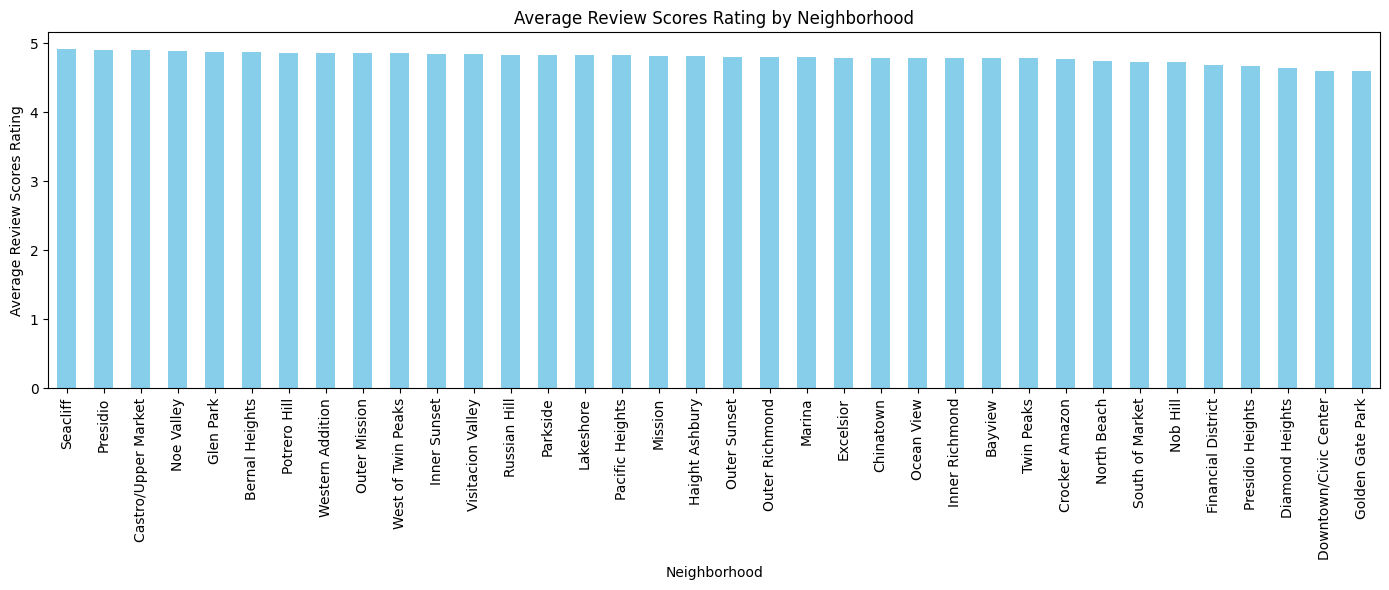

Average Review Scores Rating by Neighborhood:
neighbourhood_cleansed
Seacliff                 4.910833
Presidio                 4.903750
Castro/Upper Market      4.898295
Noe Valley               4.879476
Glen Park                4.876531
Bernal Heights           4.872199
Potrero Hill             4.861631
Western Addition         4.858079
Outer Mission            4.856102
West of Twin Peaks       4.850652
Inner Sunset             4.842362
Visitacion Valley        4.836061
Russian Hill             4.829184
Parkside                 4.824297
Lakeshore                4.824182
Pacific Heights          4.823444
Mission                  4.819865
Haight Ashbury           4.811496
Outer Sunset             4.803533
Outer Richmond           4.801351
Marina                   4.796987
Excelsior                4.789463
Chinatown                4.788981
Ocean View               4.788261
Inner Richmond           4.786235
Bayview                  4.780397
Twin Peaks               4.780182
Crocker Amazo

In [20]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculating average review_scores_rating per neighborhood
avg_rating_neighbourhood = listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().dropna().sort_values(ascending=False)

# Plotting the average review_scores_rating across neighborhoods
plt.figure(figsize=(14, 6))
avg_rating_neighbourhood.plot(kind='bar', color='skyblue')
plt.title('Average Review Scores Rating by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Review Scores Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Display the average review scores rating per neighborhood
print("Average Review Scores Rating by Neighborhood:")
print(avg_rating_neighbourhood)

# 6. Outlier Detection

Identify outliers in the dataset, particularly in price, minimum_nights, and review_scores_rating.

# Detecting outliers using IQR

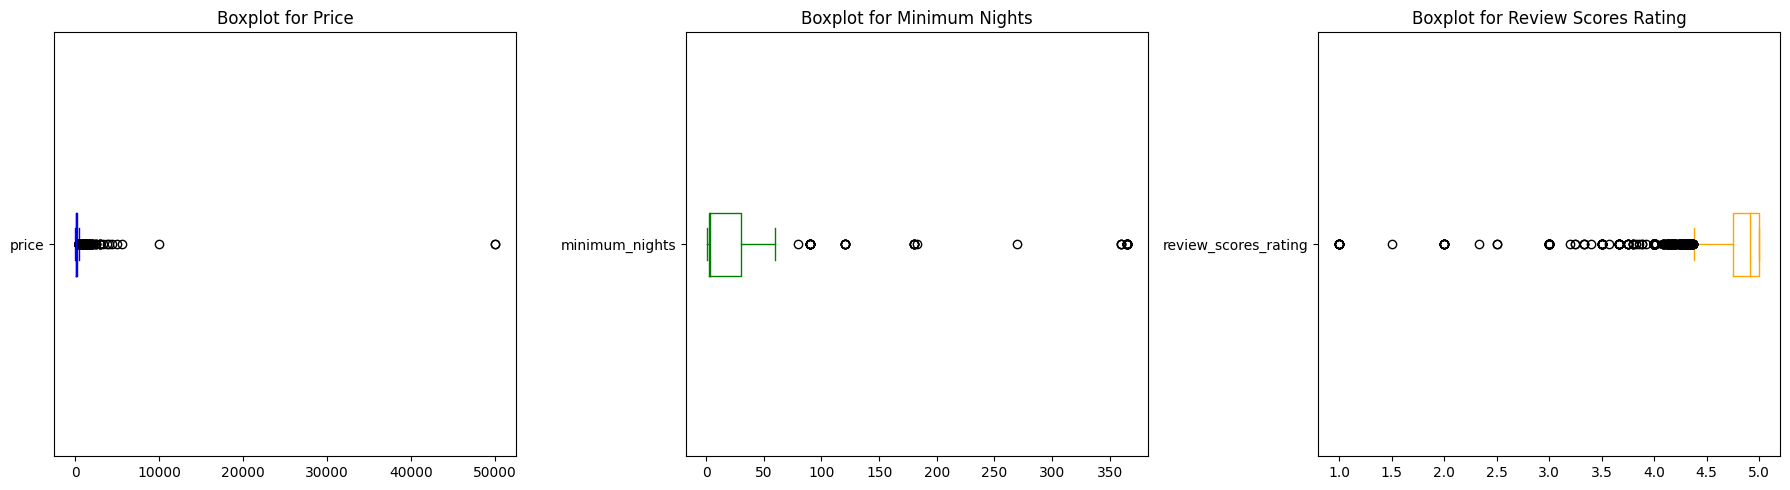

Number of price outliers: 459
        price
55     1500.0
85      950.0
92      500.0
95     4950.0
122     630.0
...       ...
7783    528.0
7794   1000.0
7796    545.0
7798    631.0
7803  10000.0

[459 rows x 1 columns]

Number of minimum nights outliers: 182
      minimum_nights
41               180
113              365
441              180
442              365
445              365
...              ...
7588              90
7656             365
7662             365
7762             360
7763             365

[182 rows x 1 columns]

Number of review scores rating outliers: 461
      review_scores_rating
6                     4.20
7                     4.11
33                    4.33
35                    4.36
37                    4.00
...                    ...
7765                  4.00
7766                  1.00
7781                  3.00
7789                  3.67
7790                  4.00

[461 rows x 1 columns]


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to check for outliers
outlier_columns = ['price', 'minimum_nights', 'review_scores_rating']

# Function to detect outliers using IQR
def detect_outliers_iqr(listings_1, column):
    Q1 = listings[column].quantile(0.25)
    Q3 = listings[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = listings[(listings[column] < lower_bound) | (listings[column] > upper_bound)]
    return outliers

# Detecting outliers for each column
outliers_price = detect_outliers_iqr(listings_1, 'price')
outliers_minimum_nights = detect_outliers_iqr(listings_1, 'minimum_nights')
outliers_review_scores = detect_outliers_iqr(listings_1, 'review_scores_rating')

# Visualizing outliers with boxplots
plt.figure(figsize=(18, 5))

# Boxplot for price
plt.subplot(1, 3, 1)
listings_1['price'].plot(kind='box', vert=False, color='blue')
plt.title('Boxplot for Price')

# Boxplot for minimum nights
plt.subplot(1, 3, 2)
listings_1['minimum_nights'].plot(kind='box', vert=False, color='green')
plt.title('Boxplot for Minimum Nights')

# Boxplot for review scores rating
plt.subplot(1, 3, 3)
listings_1['review_scores_rating'].plot(kind='box', vert=False, color='orange')
plt.title('Boxplot for Review Scores Rating')

plt.tight_layout()
plt.show()

# Display the outliers
print(f"Number of price outliers: {len(outliers_price)}")
print(outliers_price[['price']])

print(f"\nNumber of minimum nights outliers: {len(outliers_minimum_nights)}")
print(outliers_minimum_nights[['minimum_nights']])

print(f"\nNumber of review scores rating outliers: {len(outliers_review_scores)}")
print(outliers_review_scores[['review_scores_rating']])

# Outlier Detection using Z Score Technique  

Number of outliers detected: 258
        price  minimum_nights  review_scores_rating
41        NaN             180                  4.86
62      190.0               2                  3.00
95     4950.0               3                  5.00
96      150.0               3                  2.33
102     176.0               1                  3.00
...       ...             ...                   ...
7762     90.0             360                  4.22
7763    180.0             365                  4.64
7766     50.0              30                  1.00
7781    116.0               1                  3.00
7803  10000.0              45                  4.95

[258 rows x 3 columns]


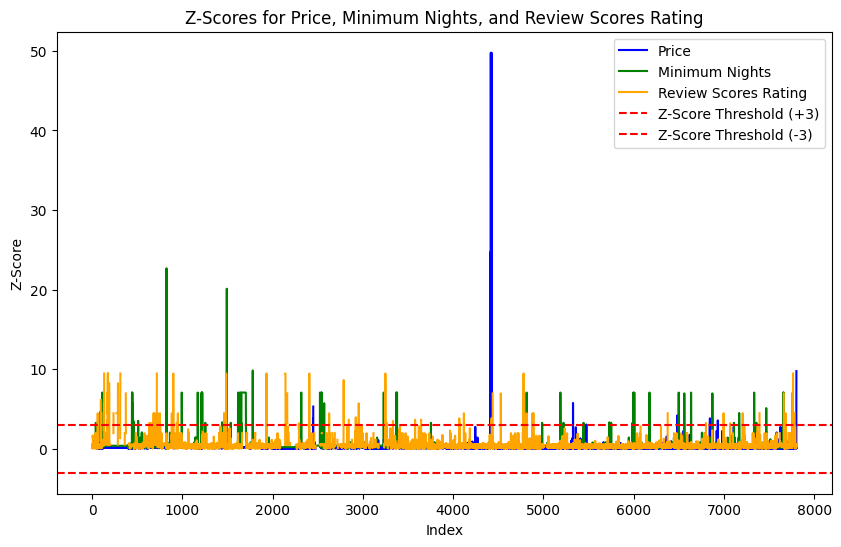

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# List of columns to check for outliers
outlier_columns = ['price', 'minimum_nights', 'review_scores_rating']

# Standardizing (z-scoring) the data for outlier detection
z_scores = np.abs((listings[outlier_columns] - listings[outlier_columns].mean()) / listings[outlier_columns].std())

# Detecting outliers with a z-score threshold of 3
outliers = listings[(z_scores > 3).any(axis=1)]

# Checking for outliers in specific columns
print(f"Number of outliers detected: {len(outliers)}")
print(outliers[outlier_columns])

# Plotting the z-scores with colors for each property
plt.figure(figsize=(10, 6))

# Plot each property with a different color
plt.plot(z_scores['price'], label='Price', color='blue')
plt.plot(z_scores['minimum_nights'], label='Minimum Nights', color='green')
plt.plot(z_scores['review_scores_rating'], label='Review Scores Rating', color='orange')

# Add z-score threshold line at 3 and -3
plt.axhline(y=3, color='red', linestyle='--', label='Z-Score Threshold (+3)')
plt.axhline(y=-3, color='red', linestyle='--', label='Z-Score Threshold (-3)')

# Add labels and title
plt.title('Z-Scores for Price, Minimum Nights, and Review Scores Rating')
plt.xlabel('Index')
plt.ylabel('Z-Score')

# Add legend to show which color represents which property
plt.legend()

# Show the plot
plt.show()
